In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from scipy.stats import zscore
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima


ModuleNotFoundError: No module named 'pmdarima'

In [2]:
#read data into df 
df = pd.read_csv("/Users/luffy_015/Desktop/WATER/final_data.csv")

/var/folders/6f/hrr6km6x5l39n_12_r7994t00000gn/T/ipykernel_37818/3026616376.py:1: DtypeWarning: Columns (17,18,20,22,23,25,26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/Users/luffy_015/Desktop/WATER/final_data.csv")


In [3]:
#reshape data to separate results column 
df_wide = df.pivot_table(
    index=["sample_date_time"],
    columns="determinand_label",
    values="result",
    aggfunc="first"
).reset_index()

# flatten the column hierarchy (pivot_table can create MultiIndex columns)
df_wide.columns.name = None  # remove the name from columns
df_wide.head()


,sample_date_time,Ammonia(N),BOD ATU,Nitrate-N,Sld Sus@105C,pH
0,2018-01-02 07:50:00,NaN,NaN,NaN,NaN,8.00
1,2018-01-02 07:53:00,0.0330,NaN,6.030,10.20,NaN
2,2018-01-02 08:07:00,0.0191,NaN,1.940,8.07,7.90
3,2018-01-02 08:21:00,0.0028,NaN,0.431,NaN,7.97
4,2018-01-02 08:26:00,0.0660,NaN,3.080,16.90,7.89


In [4]:
df_wide = df.pivot_table(
    index=['sample_date_time', 'northing', 'easting', 'local_authority_name',
       'sample_type', 'year', 'industry', 'offices', 'retail', 'storage_and_warehousing',
       'industry_and_commerce_total', 'landfill_and_waste_disposal',
       'minerals_and_mining', 'minerals_and_landfill_total',
       'institutional_and_communal_accommodations', 'residential',
       'residential_total', 'highways_and_road_transport', 'transport_other',
       'utilities', 'transport_and_utilities_total', 'agricultural_buildings',
       'agricultural_land', 'agriculture_total', 'grand_total'],
    columns="determinand_label",
    values="result",
    aggfunc="first"
).reset_index()
#drop rows that do not have all paramateres measured so df only contains sampling points where all the parameters have been measured and theres no missing data 
df = df_wide.dropna().copy()


In [5]:
#handle object dtypes that are supposed to be numeric
columns= ['industry_and_commerce_total', 'landfill_and_waste_disposal', 'minerals_and_mining', 'minerals_and_landfill_total', 'residential', 'residential_total', 'highways_and_road_transport', 'transport_other', 'utilities', 'transport_and_utilities_total', 'agricultural_buildings', 'agricultural_land', 'agriculture_total', 'grand_total'] 
for column in columns:
    df[column] = df[column].astype(str).str.strip()
    df[column] = df[column].astype(str).str.replace(r'[^0-9.]', '', regex=True)
    df[column] = pd.to_numeric(df[column])

df = df.drop(['northing', 'easting', 	
              'sample_type', 
              'offices', 
              'retail',
              'industry_and_commerce_total',
              'landfill_and_waste_disposal', 
              'minerals_and_landfill_total',
              'institutional_and_communal_accommodations',
              'residential',
              'utilities', 
              'transport_and_utilities_total', 
              'agricultural_buildings',
              'agricultural_land'], axis = 1)

print(df.isnull().sum())

determinand_label
sample_date_time                  0
local_authority_name              0
year                              0
industry                          0
storage_and_warehousing           0
minerals_and_mining            2423
residential_total                 0
highways_and_road_transport       0
transport_other                   0
agriculture_total                 0
grand_total                       0
Ammonia(N)                        0
BOD ATU                           0
Nitrate-N                         0
Sld Sus@105C                      0
pH                                0
dtype: int64


In [6]:
# handling the missing values 
df.fillna(0, inplace=True)

In [7]:
#normalise factor columns
df['industry_total'] = df['industry'] + df['storage_and_warehousing']
df['transport_total'] = df['highways_and_road_transport'] + df['transport_other']
df['industry_percentage'] = (df['industry_total'] / df['grand_total']) * 100
df['minerals_percentage'] = (df['minerals_and_mining'] / df['grand_total']) * 100 
df['residential_percentage'] = (df['residential_total'] / df['grand_total']) * 100
df['transport_percentage'] = (df['transport_total'] / df['grand_total']) * 100
df['agriculture_percentage'] = (df['agriculture_total'] / df['grand_total']) * 100

# define numeric columns
numeric_cols = ['Ammonia(N)', 'BOD ATU', 'Nitrate-N', 'Sld Sus@105C', 'pH',
       'industry_percentage', 'minerals_percentage', 'residential_percentage',
       'transport_percentage', 'agriculture_percentage']

# selecting the parameters 
parameters = ['Ammonia(N)', 'BOD ATU', 'Nitrate-N', 'Sld Sus@105C', 'pH']

/var/folders/6f/hrr6km6x5l39n_12_r7994t00000gn/T/ipykernel_37818/3619991383.py:73: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df[param_col].resample("M").mean().dropna()


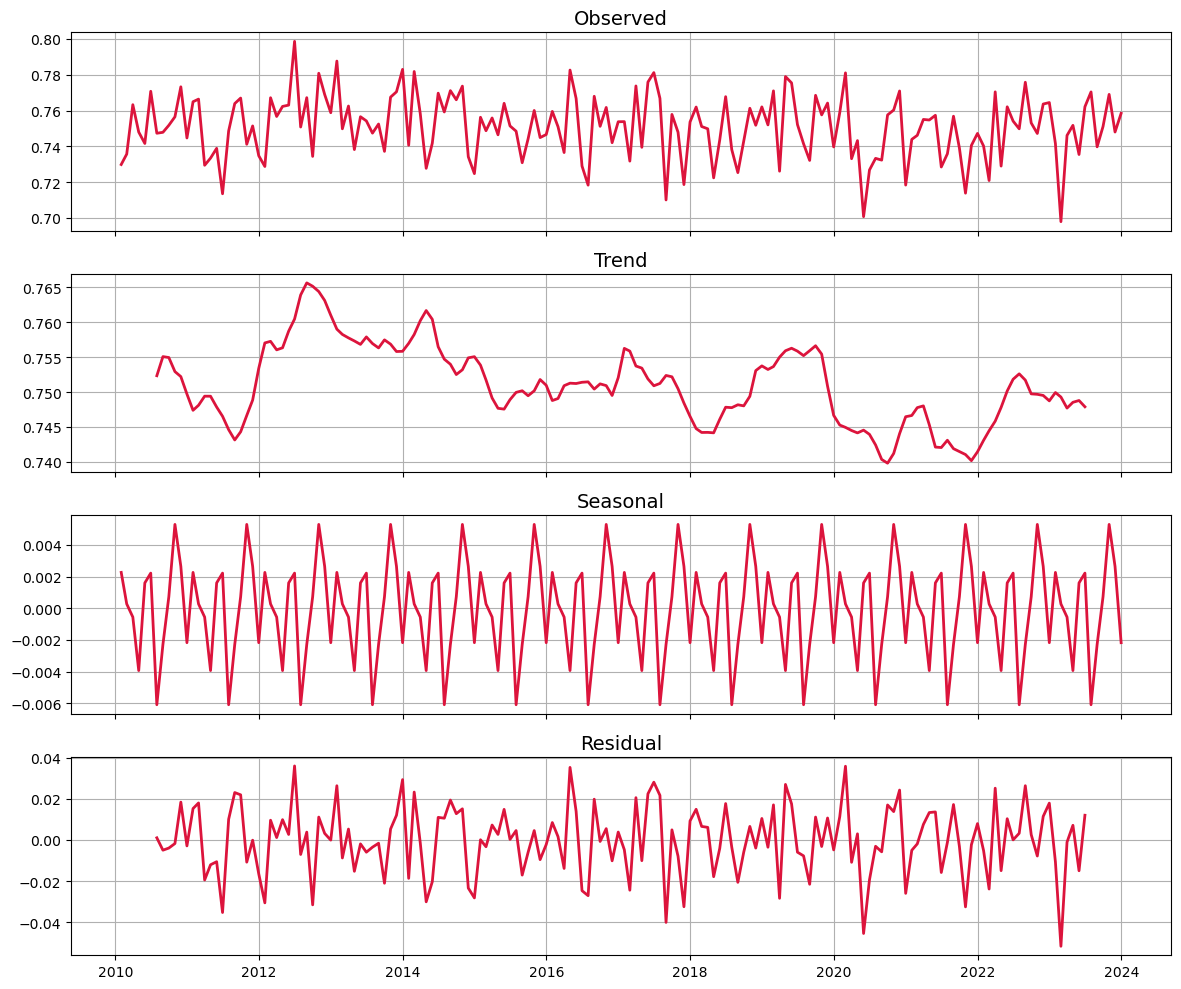

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-601.197, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-671.739, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-635.364, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-684.588, Time=0.73 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=-689.003, Time=1.62 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=-702.256, Time=2.65 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=-702.016, Time=5.42 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=4.54 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=3.42 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=-700.128, Time=6.29 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=-666.446, Time=1.66 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=-716.482, Time=3.84 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=-707.010, Time=1.66 sec
 ARIMA(2,1,0)(5,1,0)[12]          

/var/folders/6f/hrr6km6x5l39n_12_r7994t00000gn/T/ipykernel_37818/3619991383.py:103: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(


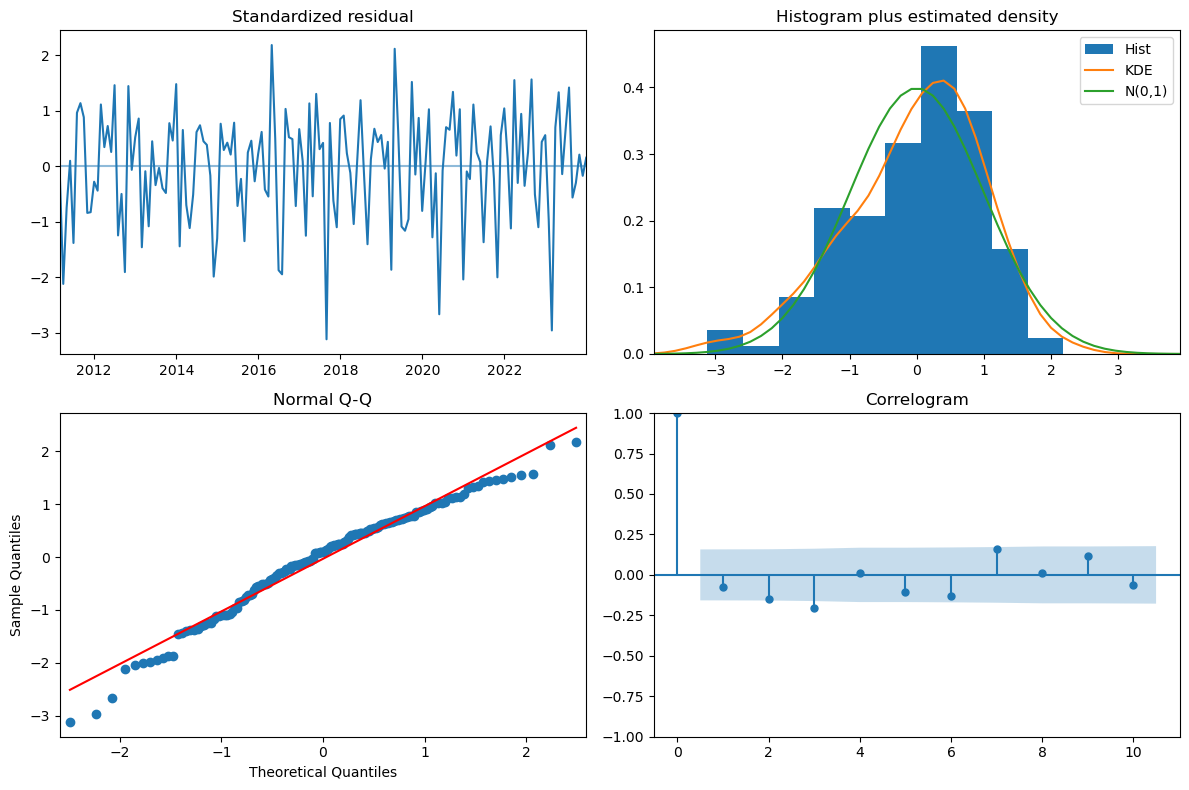

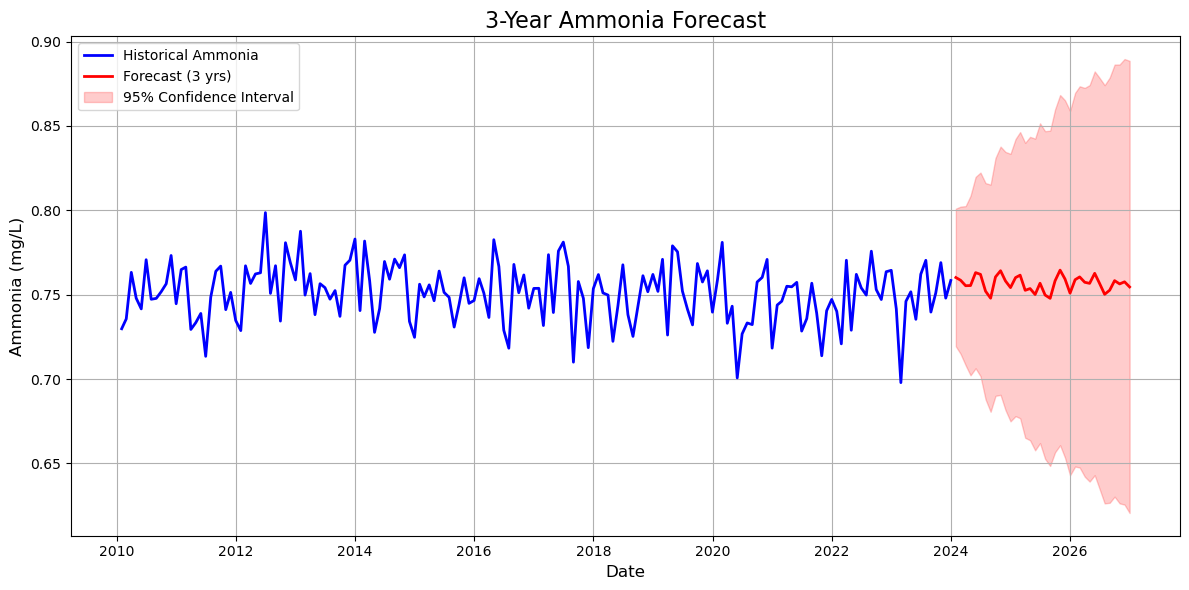

Forecast values: 2024-01-31    0.760197
2024-02-29    0.758594
2024-03-31    0.755354
2024-04-30    0.755448
2024-05-31    0.763106
2024-06-30    0.762079
2024-07-31    0.752105
2024-08-31    0.747948
2024-09-30    0.760549
2024-10-31    0.764234
2024-11-30    0.758185
2024-12-31    0.754234
2025-01-31    0.760167
2025-02-28    0.761604
2025-03-31    0.752622
2025-04-30    0.753660
2025-05-31    0.750148
2025-06-30    0.756827
2025-07-31    0.749828
2025-08-31    0.747872
2025-09-30    0.758212
2025-10-31    0.764581
2025-11-30    0.759336
2025-12-31    0.750950
2026-01-31    0.758905
2026-02-28    0.760565
2026-03-31    0.757384
2026-04-30    0.756750
2026-05-31    0.762691
2026-06-30    0.756698
2026-07-31    0.750270
2026-08-31    0.752698
2026-09-30    0.758350
2026-10-31    0.756412
2026-11-30    0.757656
2026-12-31    0.754623
Freq: ME, dtype: float64
Confidence intervals:                lower     upper
2024-01-31  0.719392  0.801003
2024-02-29  0.714981  0.802208
2024-03-31  0.7

In [8]:
#make a function to do the time series decomposition 
def plot_seasonal_decompose(series):
    
    result = seasonal_decompose(series, model='additive')
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    
    # observed
    axes[0].plot(result.observed, color='crimson', linewidth=2)
    axes[0].set_title('Observed', fontsize=14)
    axes[0].grid(True)
    
    # trend
    axes[1].plot(result.trend, color='crimson', linewidth=2)
    axes[1].set_title('Trend', fontsize=14)
    axes[1].grid(True)
    
    # seasonal
    axes[2].plot(result.seasonal, color='crimson', linewidth=2)
    axes[2].set_title('Seasonal', fontsize=14)
    axes[2].grid(True)
    
    # residual
    axes[3].plot(result.resid, color='crimson', linewidth=2)
    axes[3].set_title('Residual', fontsize=14)
    axes[3].grid(True)
    
    plt.tight_layout()
    plt.show()
    
#define function that plots decomposition 
def plot_diagnostics(results):
    
    # statsmodels' built-in diagnostic plots
    fig = results.plot_diagnostics(figsize=(12, 8))
    plt.tight_layout()
    plt.show()

def forecast_ammonia_3yr(
    df,
    date_col="sample_date_time",
    param_col="Ammonia(N)",
    ammonia_min=0.5,
    ammonia_max=1.0
):
    
    # drop missing values in the Ammonia column
    df = df.dropna(subset=[param_col]).copy()
    
    # compute z-scores for Ammonia(N) and remove extreme outliers (|z| < 3)
    df["zscore"] = zscore(df[param_col])
    df = df[df["zscore"].abs() < 3].copy()
    
    # remove invalid ammonia values outside [ammonia_min, ammonia_max]
    df = df[(df[param_col] >= ammonia_min) & (df[param_col] <= ammonia_max)].copy()
    
    # convert to Datetime, sort by date, and set as index
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df.sort_values(by=date_col, inplace=True)
    df.set_index(date_col, inplace=True)
    
    # resample to monthly means
    df_monthly = df[param_col].resample("M").mean().dropna()
    
    # need at least 12 months of data to capture seasonality
    if len(df_monthly) < 12:
        raise ValueError("Not enough data after filtering and resampling.")
    
    # plot seasonal decomposition
    plot_seasonal_decompose(df_monthly)
    
    # fit Auto ARIMA model
    try:
        auto_model = auto_arima(
            df_monthly,
            seasonal=True,
            m=12,
            start_p=0, start_q=0, max_p=5, max_q=5,
            start_P=0, start_Q=0, max_P=5, max_Q=5,
            d=1, D=1, trace=True, error_action='ignore',
            suppress_warnings=True, stepwise=True
        )
        
        # generate forecast directly from auto_arima model
        forecast_steps = 36  # 3 years of monthly forecasts
        forecast_vals, conf_int = auto_model.predict(
            n_periods=forecast_steps,
            return_conf_int=True
        )
        
        # create future index for plotting
        last_date = df_monthly.index[-1]
        future_index = pd.date_range(
            start=last_date + pd.DateOffset(months=1),
            periods=forecast_steps,
            freq='M'
        )
        
        # convert to pandas Series and DataFrame
        forecast_vals = pd.Series(forecast_vals, index=future_index)
        conf_int = pd.DataFrame(
            conf_int,
            index=future_index,
            columns=['lower', 'upper']
        )
        
        # print model summary
        print(auto_model.summary())
        
        # Plot diagnostics
        plot_diagnostics(auto_model)
        
    except Exception as e:
        print(f"Error fitting the model: {e}")
        return None, None

    # plot Historical Data + Future Forecast
    plt.figure(figsize=(12, 6))
    
    # plot historical ammonia
    plt.plot(
        df_monthly.index, 
        df_monthly, 
        label="Historical Ammonia", 
        color="blue", 
        linewidth=2
    )
    
    # plot forecast
    plt.plot(
        future_index, 
        forecast_vals, 
        label="Forecast (3 yrs)", 
        color="red", 
        linewidth=2
    )
    
    # confidence intervals
    plt.fill_between(
        future_index,
        conf_int['lower'],
        conf_int['upper'],
        color="red",
        alpha=0.2,
        label="95% Confidence Interval"
    )
    
    # add grid, legend, and labels
    plt.title("3-Year Ammonia Forecast", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Ammonia (mg/L)", fontsize=12)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return forecast_vals, conf_int


# Usage
if __name__ == "__main__":
    # generate a synthetic daily date range
    date_rng = pd.date_range("2010-01-01", "2023-12-01", freq="D")
    
    # Create synthetic Ammonia(N) data centered ~0.75 mg/L with some noise
    np.random.seed(42)
    synthetic_ammonia = 0.75 + np.random.normal(loc=0, scale=0.1, size=len(date_rng))
    
    # build a df
    df_demo = pd.DataFrame({
        "sample_date_time": date_rng,
        "Ammonia(N)": synthetic_ammonia
    })
    
    # forecast with ammonia range [0.5, 1.0]
    forecast, confidence_intervals = forecast_ammonia_3yr(
        df_demo,
        date_col="sample_date_time",
        param_col="Ammonia(N)",
        ammonia_min=0.5,
        ammonia_max=1.0
    )
    
    print("Forecast values:", forecast)
    print("Confidence intervals:", confidence_intervals)


/var/folders/6f/hrr6km6x5l39n_12_r7994t00000gn/T/ipykernel_37818/1434355420.py:64: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df[param_col].resample("M").mean().dropna()


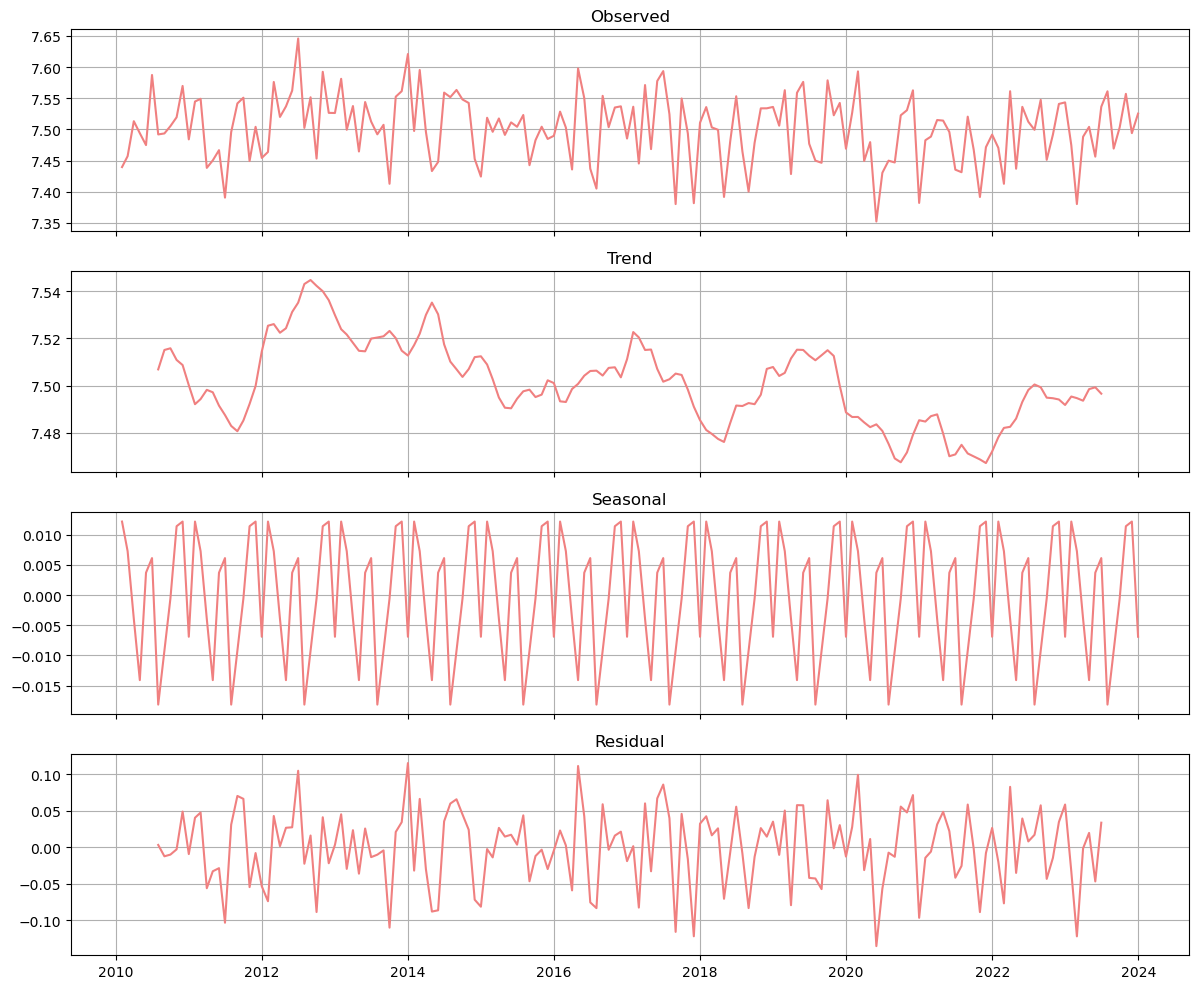

                                     SARIMAX Results                                      
Dep. Variable:                                 pH   No. Observations:                  168
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 190.916
Date:                            Fri, 21 Mar 2025   AIC                           -371.832
Time:                                    14:43:10   BIC                           -357.088
Sample:                                01-31-2010   HQIC                          -365.840
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0479      0.102      0.468      0.640      -0.153       0.249
ma.L1         -1.0000     83.780   

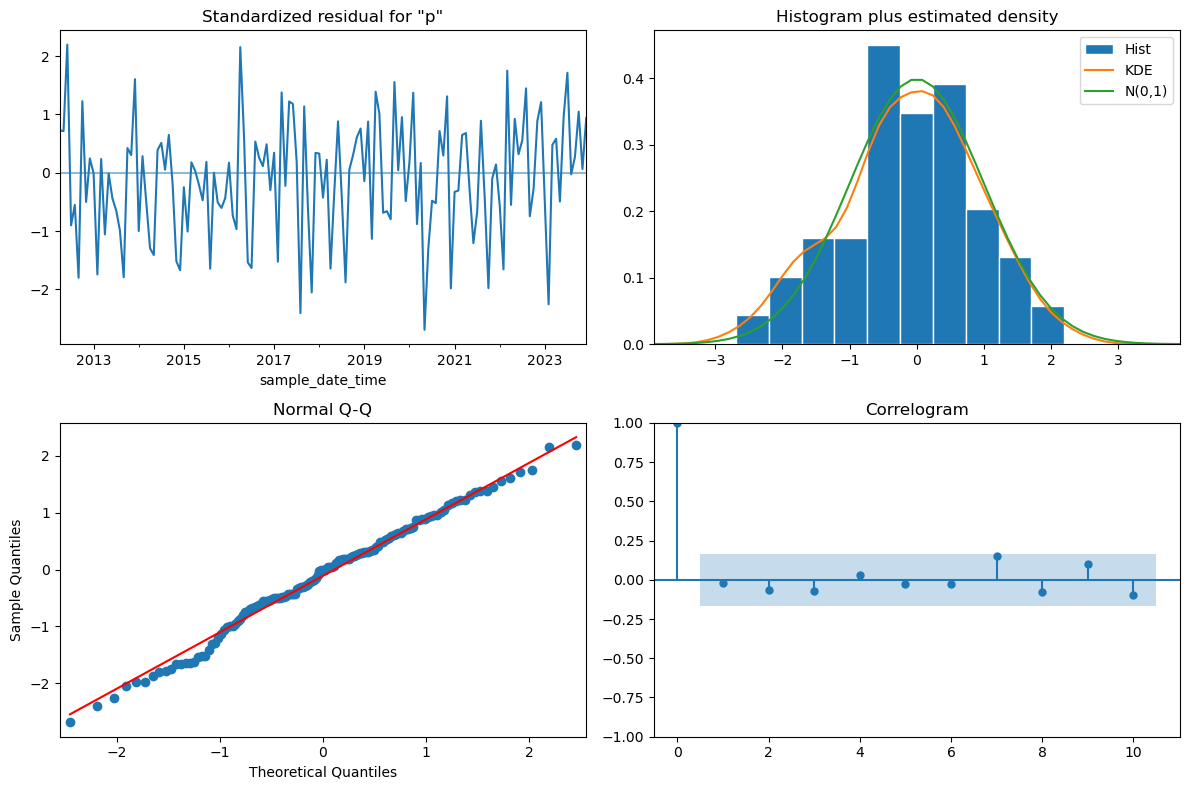

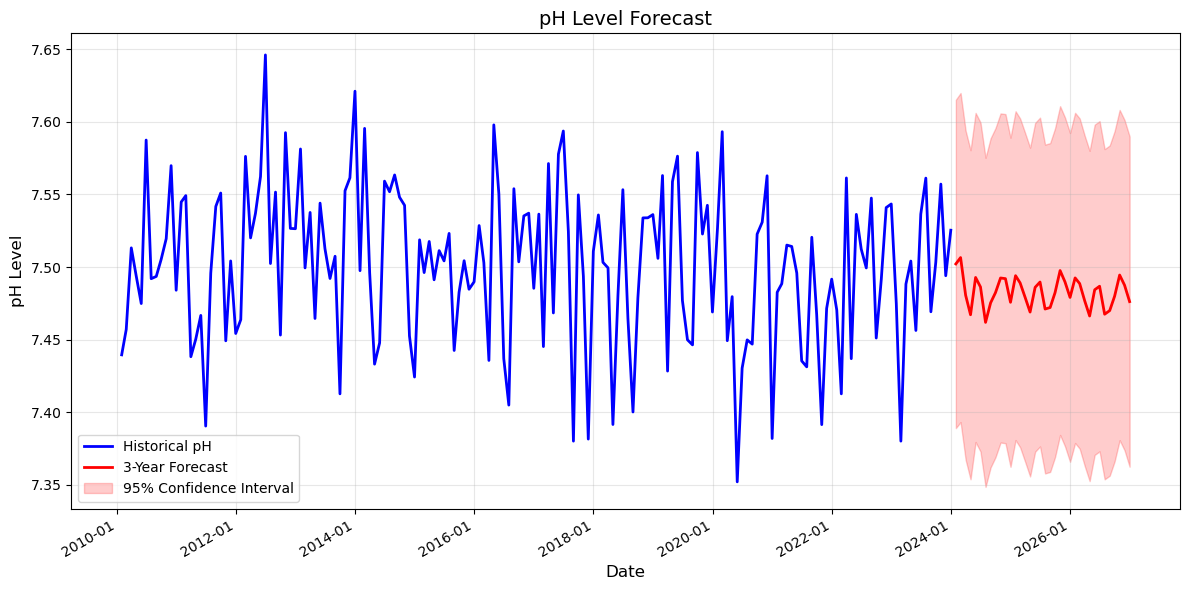


Forecast Summary:
        Forecast   Lower CI   Upper CI
count  36.000000  36.000000  36.000000
mean    7.482908   7.369555   7.596261
std     0.010747   0.010788   0.010710
min     7.461897   7.348636   7.575158
25%     7.475633   7.362367   7.588899
50%     7.483360   7.369934   7.596818
75%     7.490303   7.377117   7.603490
max     7.506513   7.393258   7.619768


In [9]:
def plot_seasonal_decompose(series):
    
    result = seasonal_decompose(series, model='additive')
    fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    
    axes[0].plot(result.observed, color='lightcoral', linewidth=1.5)
    axes[0].set_title('Observed', fontsize=12)
    axes[0].grid(True)
    
    axes[1].plot(result.trend, color='lightcoral', linewidth=1.5)
    axes[1].set_title('Trend', fontsize=12)
    axes[1].grid(True)
    
    axes[2].plot(result.seasonal, color='lightcoral', linewidth=1.5)
    axes[2].set_title('Seasonal', fontsize=12)
    axes[2].grid(True)
    
    axes[3].plot(result.resid, color='lightcoral', linewidth=1.5)
    axes[3].set_title('Residual', fontsize=12)
    axes[3].grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_diagnostics(results):
    
    fig = results.plot_diagnostics(figsize=(12, 8))
    plt.tight_layout()
    plt.show()

def forecast_ph_3yr(
    df: pd.DataFrame,
    date_col: str = "sample_date_time",
    param_col: str = "pH",
    ph_min: float = 5.5,
    ph_max: float = 9.5
) -> tuple[pd.Series, pd.DataFrame]:
    
    # data preprocessing
    df = df.dropna(subset=[param_col]).copy()
    
    # remove outliers using Z-score (|z| < 3)
    df["zscore"] = zscore(df[param_col])
    df = df[df["zscore"].abs() < 3].copy()
    
    # remove invalid pH values
    df = df[(df[param_col] >= ph_min) & (df[param_col] <= ph_max)].copy()

    # datetime handling
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.dropna(subset=[date_col]).copy()
    df.sort_values(by=date_col, inplace=True)
    df.set_index(date_col, inplace=True)
    
    # resample to monthly means
    df_monthly = df[param_col].resample("M").mean().dropna()
    
    if len(df_monthly) < 12:
        raise ValueError("Minimum 12 months of data required after processing.")
    
    # seasonal decomposition analysis
    plot_seasonal_decompose(df_monthly)
    
    try:
        # fit SARIMA model
        model = sm.tsa.statespace.SARIMAX(
            df_monthly,
            order=(1, 1, 1),
            seasonal_order=(1, 1, 1, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results = model.fit(disp=False)
        print(results.summary())
        plot_diagnostics(results)
        
    except Exception as e:
        print(f"Model fitting failed: {e}")
        return None, None
    
    # generate forecast
    forecast_steps = 36
    forecast_obj = results.get_forecast(steps=forecast_steps)
    forecast_vals = forecast_obj.predicted_mean
    conf_int = forecast_obj.conf_int()
    
    # visualization
    plt.figure(figsize=(12, 6))
    plt.plot(df_monthly.index, df_monthly, 
             label="Historical pH", color="blue", linewidth=2)
    plt.plot(forecast_vals.index, forecast_vals, 
             label="3-Year Forecast", color="red", linewidth=2)
    plt.fill_between(conf_int.index,
                    conf_int.iloc[:, 0],
                    conf_int.iloc[:, 1],
                    color="red", alpha=0.2,
                    label="95% Confidence Interval")
    
    plt.title(f"pH Level Forecast", 
              fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("pH Level", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Use mdates here
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()
    
    return forecast_vals, conf_int


if __name__ == "__main__":
    # generate synthetic data
    date_rng = pd.date_range("2010-01-01", "2023-12-01", freq="D")
    np.random.seed(42)
    synthetic_pH = 7.5 + np.random.normal(loc=0, scale=0.3, size=len(date_rng))
    
    df_demo = pd.DataFrame({
        "sample_date_time": date_rng,
        "pH": np.clip(synthetic_pH, 5.5, 9.5)  # Hard-clip to valid range
    })
    
    # run forecasting
    forecast, conf_int = forecast_ph_3yr(
        df_demo,
        ph_min=5.5,
        ph_max=9.5
    )
    
    if forecast is not None:
        print("\nForecast Summary:")
        print(pd.DataFrame({
            'Forecast': forecast,
            'Lower CI': conf_int.iloc[:, 0],
            'Upper CI': conf_int.iloc[:, 1]
        }).describe())


/var/folders/6f/hrr6km6x5l39n_12_r7994t00000gn/T/ipykernel_37818/3563484606.py:72: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df[param_col].resample("M").mean().dropna()


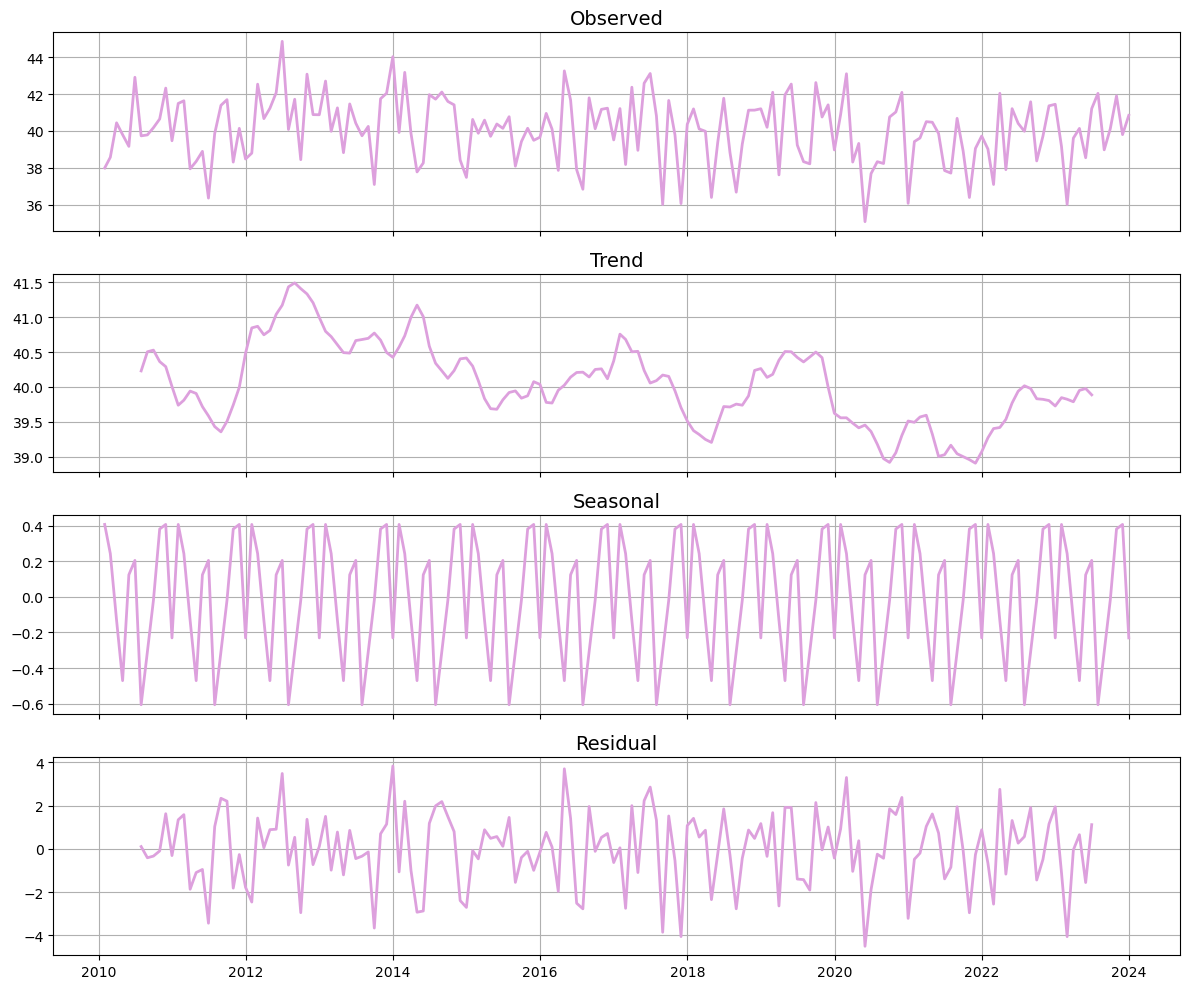

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=838.552, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=770.836, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=805.743, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=754.874, Time=0.18 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=749.559, Time=0.41 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=735.722, Time=0.79 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=735.773, Time=1.44 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=6.29 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.29 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=8.44 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=768.079, Time=0.52 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=722.409, Time=0.87 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=732.671, Time=0.38 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=720.26

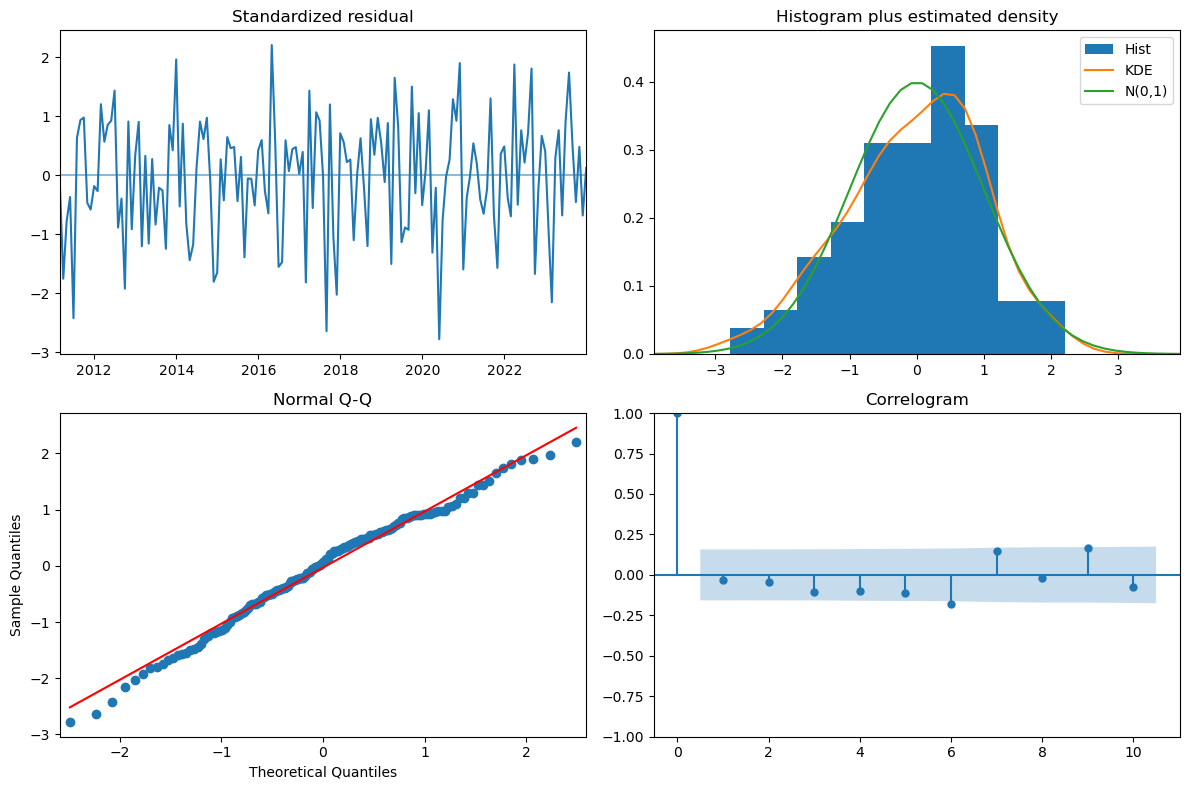

/var/folders/6f/hrr6km6x5l39n_12_r7994t00000gn/T/ipykernel_37818/3563484606.py:106: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(


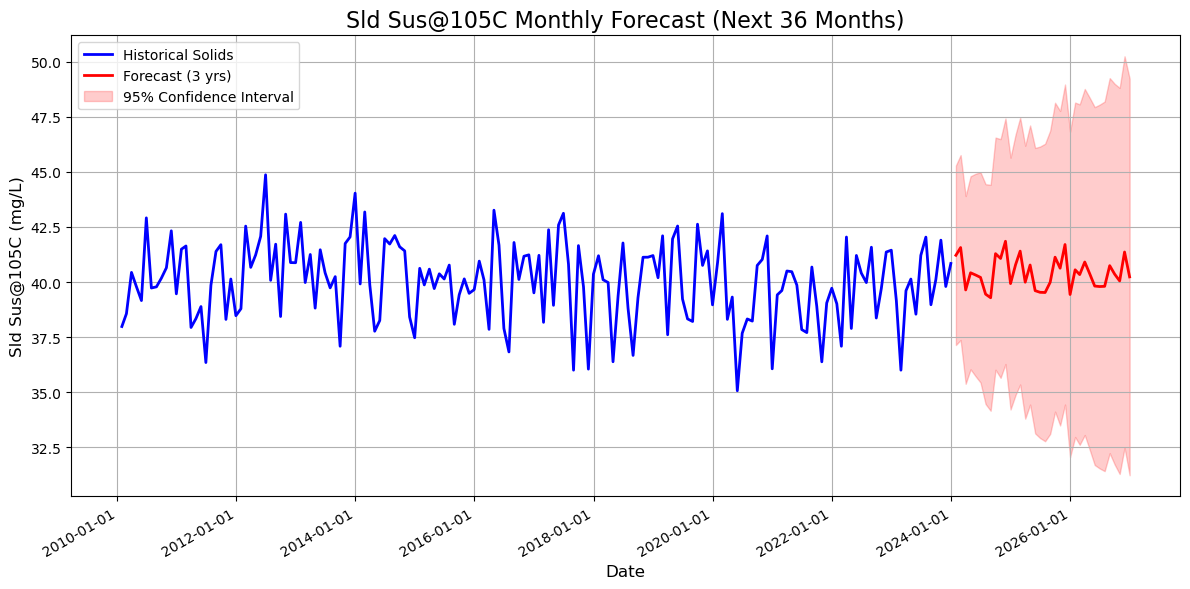

Forecast values: 2024-01-31    41.215631
2024-02-29    41.566208
2024-03-31    39.644195
2024-04-30    40.422002
2024-05-31    40.320978
2024-06-30    40.212343
2024-07-31    39.454101
2024-08-31    39.289237
2024-09-30    41.289973
2024-10-31    41.071443
2024-11-30    41.851951
2024-12-31    39.931703
2025-01-31    40.790757
2025-02-28    41.404475
2025-03-31    39.995723
2025-04-30    40.774464
2025-05-31    39.610625
2025-06-30    39.536637
2025-07-31    39.527922
2025-08-31    39.991007
2025-09-30    41.129260
2025-10-31    40.630348
2025-11-30    41.704075
2025-12-31    39.437256
2026-01-31    40.557273
2026-02-28    40.340403
2026-03-31    40.911205
2026-04-30    40.386167
2026-05-31    39.819926
2026-06-30    39.797880
2026-07-31    39.807542
2026-08-31    40.746263
2026-09-30    40.363828
2026-10-31    40.051969
2026-11-30    41.364220
2026-12-31    40.236054
Freq: ME, dtype: float64
Confidence intervals: [[37.14422958 45.28703276]
 [37.37183049 45.76058565]
 [35.38622869 43.9

In [10]:
def plot_seasonal_decompose(series):

    result = seasonal_decompose(series, model='additive')
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    # observed
    axes[0].plot(result.observed, color='plum', linewidth=2)
    axes[0].set_title('Observed', fontsize=14)
    axes[0].grid(True)

    # trend
    axes[1].plot(result.trend, color='plum', linewidth=2)
    axes[1].set_title('Trend', fontsize=14)
    axes[1].grid(True)

    # seasonal
    axes[2].plot(result.seasonal, color='plum', linewidth=2)
    axes[2].set_title('Seasonal', fontsize=14)
    axes[2].grid(True)

    # residual
    axes[3].plot(result.resid, color='plum', linewidth=2)
    axes[3].set_title('Residual', fontsize=14)
    axes[3].grid(True)

    # improve layout
    plt.tight_layout()
    plt.show()

def plot_diagnostics(results):
   
    fig = results.plot_diagnostics(figsize=(12, 8))
    plt.tight_layout()
    plt.show()

def forecast_sld_sus_3yr(
    df,
    date_col="sample_date_time",
    param_col="Sld Sus@105C",
    solids_min=0.0,
    solids_max=200.0
):
    
    # drop missing values
    df = df.dropna(subset=[param_col]).copy()
    
    # compute z-scores for solids and filter out extreme outliers (|z| < 3)
    df["zscore"] = zscore(df[param_col])
    df = df[df["zscore"].abs() < 3].copy()
    
    # remove invalid solids values outside the specified range
    df = df[(df[param_col] >= solids_min) & (df[param_col] <= solids_max)].copy()

    # convert the date column to datetime, sort by date, set index
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df.sort_values(by=date_col, inplace=True)
    df.set_index(date_col, inplace=True)
    
    # resample monthly (mean) and drop any empty months
    df_monthly = df[param_col].resample("M").mean().dropna()
    
    if len(df_monthly) < 12:  # Need at least 12 months to model seasonality
        raise ValueError("Not enough data after filtering and resampling.")
    
    # plot seasonal decomposition
    plot_seasonal_decompose(df_monthly)
    
    # fit auto ARIMA model
    try:
        auto_model = auto_arima(
            df_monthly, 
            seasonal=True, 
            m=12,
            start_p=0, start_q=0, max_p=5, max_q=5,
            start_P=0, start_Q=0, max_P=5, max_Q=5,
            d=1, D=1, trace=True, error_action='ignore',
            suppress_warnings=True, stepwise=True
        )
        
        results = auto_model.fit(df_monthly)
        print(results.summary())
        
        # plot model diagnostics
        plot_diagnostics(results)
    except Exception as e:
        print(f"Error fitting the model: {e}")
        return None, None
    
    # forecast for 3 years (36 months)
    forecast_steps = 36
    forecast_vals, conf_int = results.predict(n_periods=forecast_steps, return_conf_int=True)
    
    # create future index for plotting
    future_index = pd.date_range(
        start=df_monthly.index[-1] + pd.Timedelta(days=1), 
        periods=forecast_steps, 
        freq='M'
    )
    
    # plot Historical + Future Forecast
    plt.figure(figsize=(12, 6))
    
    # plot historical data
    plt.plot(
        df_monthly.index, 
        df_monthly, 
        label="Historical Solids", 
        color="blue", 
        linewidth=2
    )
    
    # plot forecast
    plt.plot(
        future_index, 
        forecast_vals, 
        label="Forecast (3 yrs)", 
        color="red", 
        linewidth=2
    )
    
    # confidence intervals
    plt.fill_between(
        future_index,
        conf_int[:, 0],
        conf_int[:, 1],
        color="red",
        alpha=0.2,
        label="95% Confidence Interval"
    )
    
    plt.title(f"{param_col} Monthly Forecast (Next 36 Months)", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel(f"{param_col} (mg/L)", fontsize=12)
    plt.legend()
    plt.grid(True)
    
    # Format x-axis for dates
    plt.gcf().autofmt_xdate()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    plt.tight_layout()
    plt.show()

    return forecast_vals, conf_int


if __name__ == "__main__":
    # synthetic data from 2010-01 to 2023-12, daily frequency
    date_rng = pd.date_range("2010-01-01", "2023-12-01", freq="D")
    
    # generate solids data centered ~40 mg/L with some noise
    np.random.seed(42)
    synthetic_solids = 40 + np.random.normal(loc=0, scale=10, size=len(date_rng))
    
    # build a DataFrame
    df_demo = pd.DataFrame({
        "sample_date_time": date_rng,
        "Sld Sus@105C": synthetic_solids
    })
    
    # call the forecast function
    forecast_vals, conf_int = forecast_sld_sus_3yr(
        df_demo,
        date_col="sample_date_time",
        param_col="Sld Sus@105C",
        solids_min=0.0,
        solids_max=200.0
    )
    
    if forecast_vals is not None:
        print("Forecast values:", forecast_vals)
        print("Confidence intervals:", conf_int)


/var/folders/6f/hrr6km6x5l39n_12_r7994t00000gn/T/ipykernel_37818/1534298713.py:64: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df[param_col].resample("M").mean().dropna()


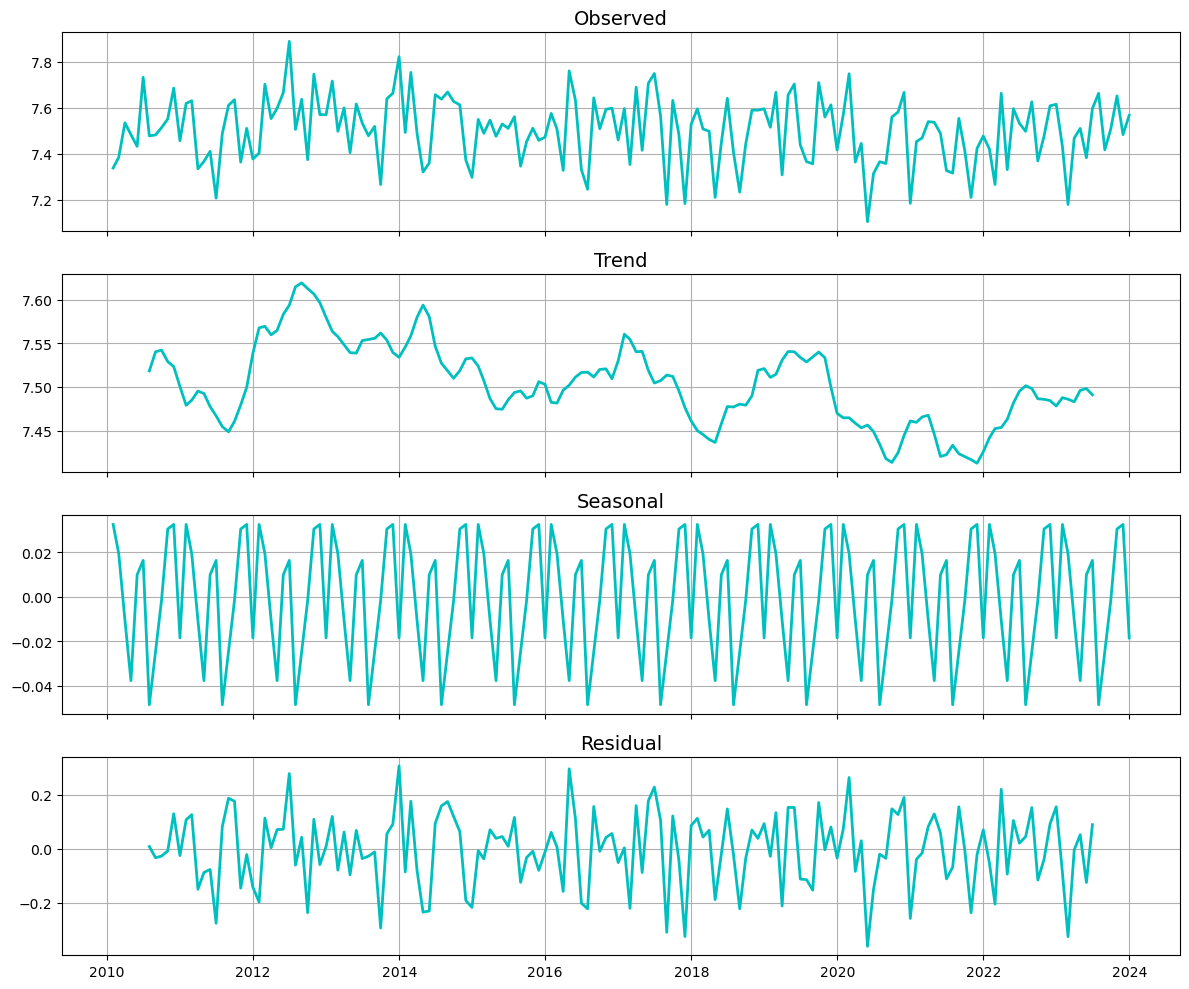

                                     SARIMAX Results                                      
Dep. Variable:                          Nitrate-N   No. Observations:                  168
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                  52.619
Date:                            Fri, 21 Mar 2025   AIC                            -95.238
Time:                                    14:45:48   BIC                            -80.494
Sample:                                01-31-2010   HQIC                           -89.247
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0479      0.102      0.468      0.640      -0.153       0.249
ma.L1         -1.0000    148.421   

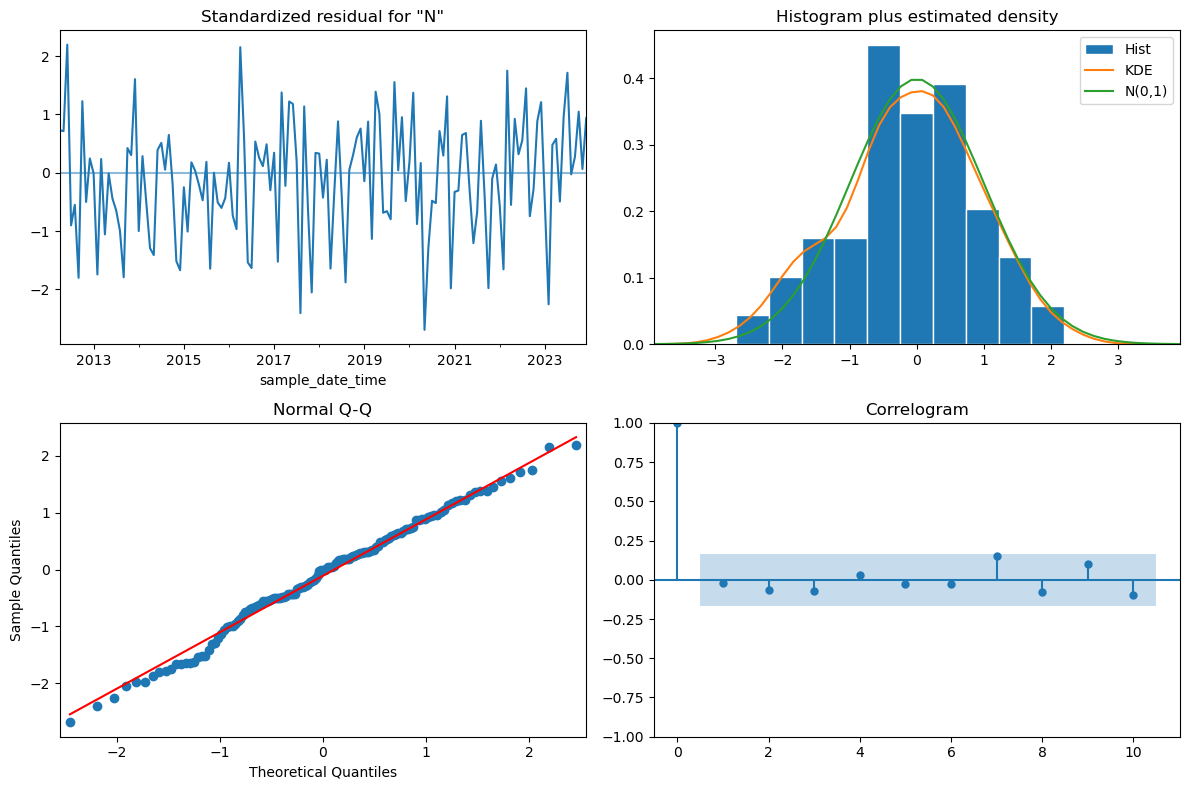

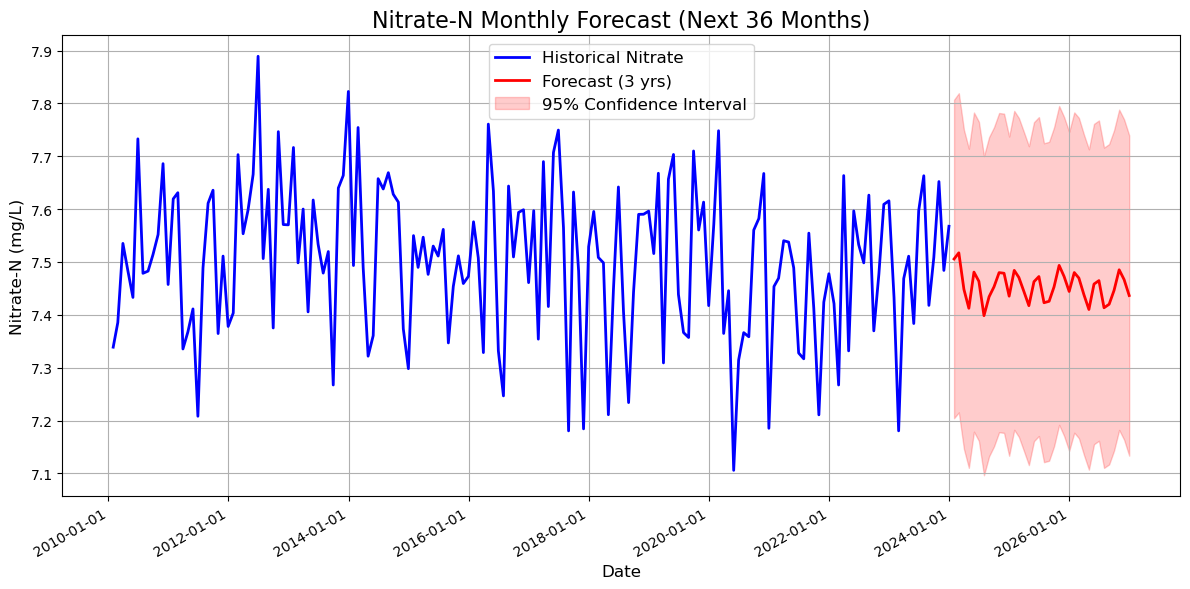

Forecast values: 2024-01-31    7.505676
2024-02-29    7.517352
2024-03-31    7.448172
2024-04-30    7.412396
2024-05-31    7.480829
2024-06-30    7.463394
2024-07-31    7.398405
2024-08-31    7.434218
2024-09-30    7.453033
2024-10-31    7.479887
2024-11-30    7.478653
2024-12-31    7.435296
2025-01-31    7.484136
2025-02-28    7.470776
2025-03-31    7.443929
2025-04-30    7.417339
2025-05-31    7.462740
2025-06-30    7.472467
2025-07-31    7.422902
2025-08-31    7.425649
2025-09-30    7.452940
2025-10-31    7.493506
2025-11-30    7.472638
2025-12-31    7.444208
2026-01-31    7.480022
2026-02-28    7.469607
2026-03-31    7.437781
2026-04-30    7.410111
2026-05-31    7.458220
2026-06-30    7.464753
2026-07-31    7.413374
2026-08-31    7.420010
2026-09-30    7.446304
2026-10-31    7.485257
2026-11-30    7.466698
2026-12-31    7.436512
Freq: ME, Name: predicted_mean, dtype: float64
Confidence intervals:             lower Nitrate-N  upper Nitrate-N
2024-01-31         7.204266         7.807

In [11]:
def plot_seasonal_decompose(series):
    
    result = seasonal_decompose(series, model='additive')
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    
    # observed
    axes[0].plot(result.observed, color='c', linewidth=2)
    axes[0].set_title('Observed', fontsize=14)
    axes[0].grid(True)
    
    # trend
    axes[1].plot(result.trend, color='c', linewidth=2)
    axes[1].set_title('Trend', fontsize=14)
    axes[1].grid(True)
    
    # seasonal
    axes[2].plot(result.seasonal, color='c', linewidth=2)
    axes[2].set_title('Seasonal', fontsize=14)
    axes[2].grid(True)
    
    # residual
    axes[3].plot(result.resid, color='c', linewidth=2)
    axes[3].set_title('Residual', fontsize=14)
    axes[3].grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_diagnostics(results):
    
    fig = results.plot_diagnostics(figsize=(12, 8))
    plt.tight_layout()
    plt.show()

def forecast_nitrate_3yr(df, date_col="sample_date_time", param_col="Nitrate-N"):
    # drop missing values in the parameter column
    df = df.dropna(subset=[param_col]).copy()
    
    # remove extreme outliers using the z-score method (|z| < 3)
    df["zscore"] = zscore(df[param_col])
    df = df[df["zscore"].abs() < 3].copy()
    
    # apply threshold: keep only values between 5 and 10 mg/L
    df = df[(df[param_col] >= 5) & (df[param_col] <= 10)].copy()
    
    # convert date column to datetime, sort, and set as index
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df.sort_values(by=date_col, inplace=True)
    df.set_index(date_col, inplace=True)
    
    # resample data to monthly means
    df_monthly = df[param_col].resample("M").mean().dropna()
    
    if len(df_monthly) < 12:
        raise ValueError("Not enough data after outlier removal and resampling.")
    
    # plot seasonal decomposition
    plot_seasonal_decompose(df_monthly)
    
    try:
        # fit SARIMA model (with seasonal period of 12 months)
        model = sm.tsa.statespace.SARIMAX(
            df_monthly,
            order=(1, 1, 1),
            seasonal_order=(1, 1, 1, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results = model.fit(disp=False)
        print(results.summary())
        
        # plot model diagnostics
        plot_diagnostics(results)
    except Exception as e:
        print(f"Error fitting the model: {e}")
        return None, None
    
    # forecast for 3 years 
    forecast_steps = 36
    forecast_obj = results.get_forecast(steps=forecast_steps)
    forecast_vals = forecast_obj.predicted_mean
    conf_int = forecast_obj.conf_int()
    
    # plot historical data and forecast with confidence intervals
    plt.figure(figsize=(12, 6))
    
    # plot historical data
    plt.plot(
        df_monthly.index,
        df_monthly,
        label="Historical Nitrate",
        color="blue",
        linewidth=2
    )
    
    # plot forecast
    future_index = forecast_vals.index
    plt.plot(
        future_index,
        forecast_vals,
        label="Forecast (3 yrs)",
        color="red",
        linewidth=2
    )
    
    # plot confidence intervals
    plt.fill_between(
        future_index,
        conf_int.iloc[:, 0],
        conf_int.iloc[:, 1],
        color="red",
        alpha=0.2,
        label="95% Confidence Interval"
    )
    
    plt.title(f"{param_col} Monthly Forecast (Next 36 Months)", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel(f"{param_col} (mg/L)", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    
    # format the x-axis for dates
    plt.gcf().autofmt_xdate()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    plt.tight_layout()
    plt.show()

    return forecast_vals, conf_int

if __name__ == "__main__":
    # generate synthetic daily Nitrate-N data from 2010-01-01 to 2023-12-01.
    date_rng = pd.date_range("2010-01-01", "2023-12-01", freq="D")
    np.random.seed(42)
    synthetic_nitrate = 7.5 + np.random.normal(loc=0, scale=0.8, size=len(date_rng))
    
    df_demo = pd.DataFrame({
        "sample_date_time": date_rng,
        "Nitrate-N": synthetic_nitrate
    })
    
    # call the 3-year forecast function for Nitrate-N
    forecast_vals, conf_int = forecast_nitrate_3yr(df_demo, date_col="sample_date_time", param_col="Nitrate-N")
    
    if forecast_vals is not None:
        print("Forecast values:", forecast_vals)
        print("Confidence intervals:", conf_int)


/var/folders/6f/hrr6km6x5l39n_12_r7994t00000gn/T/ipykernel_37818/950111308.py:59: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df[param_col].resample("M").mean().dropna()


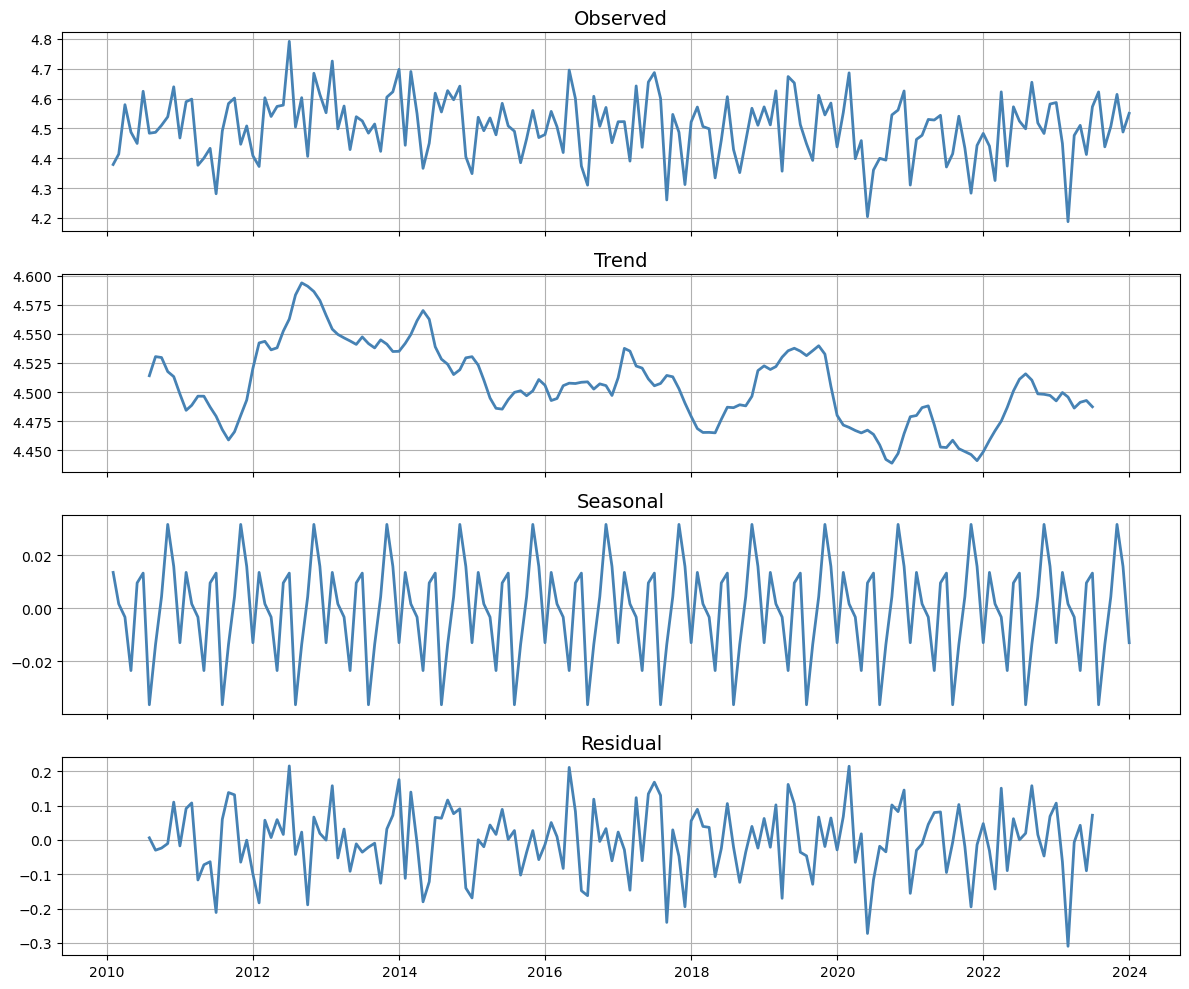

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-45.751, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-116.294, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-79.921, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-129.143, Time=0.31 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=-133.558, Time=0.75 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=-146.811, Time=1.71 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=-146.571, Time=4.03 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=6.00 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=5.65 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=11.19 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=-111.001, Time=1.48 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=-161.038, Time=1.87 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=-151.565, Time=0.72 sec
 ARIMA(2,1,0)(5,1,0)[12]             : A

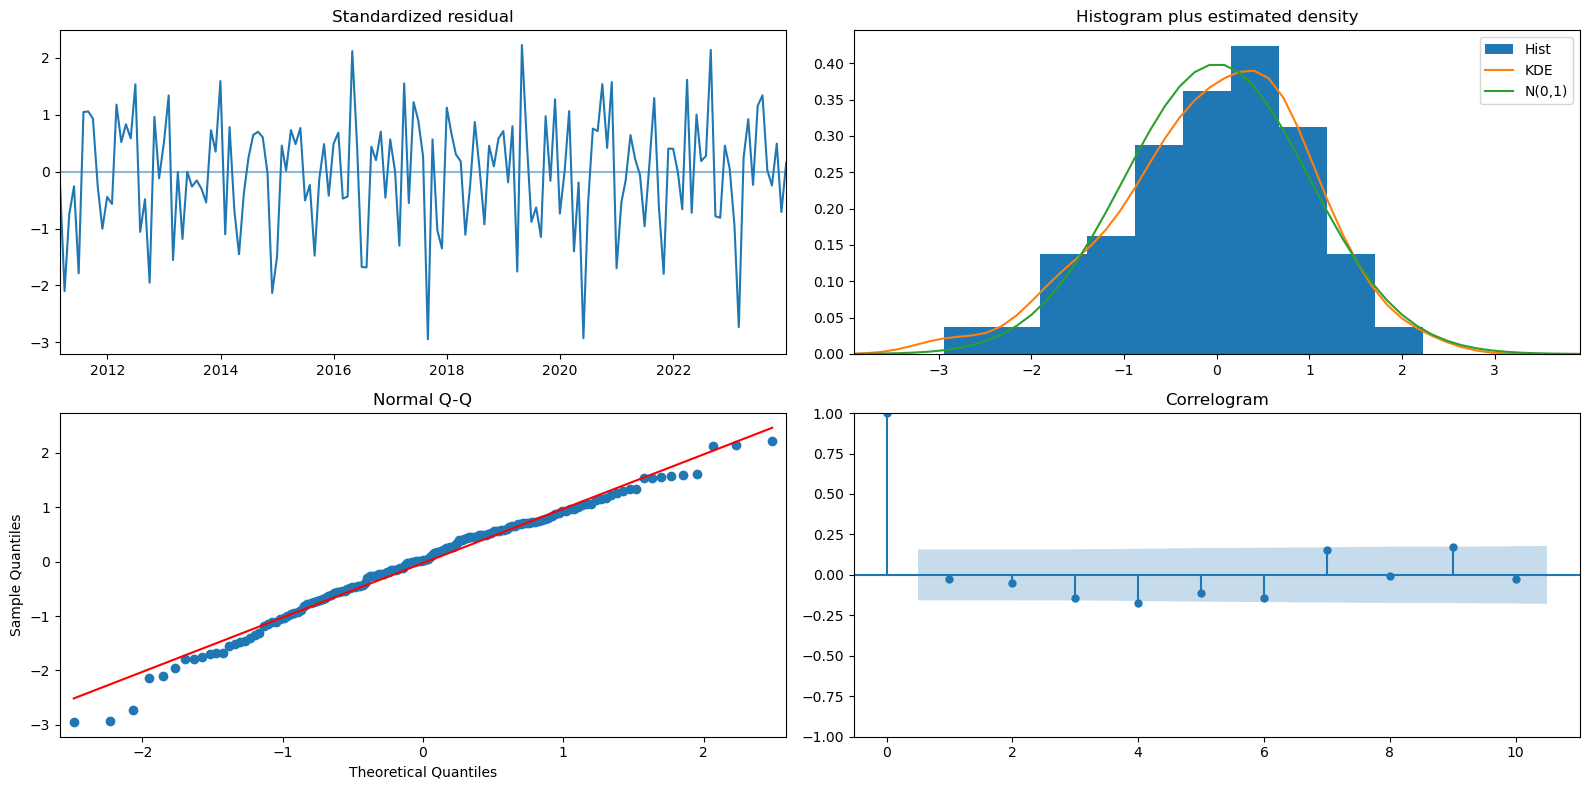

/var/folders/6f/hrr6km6x5l39n_12_r7994t00000gn/T/ipykernel_37818/950111308.py:90: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(start=df_monthly.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='M')


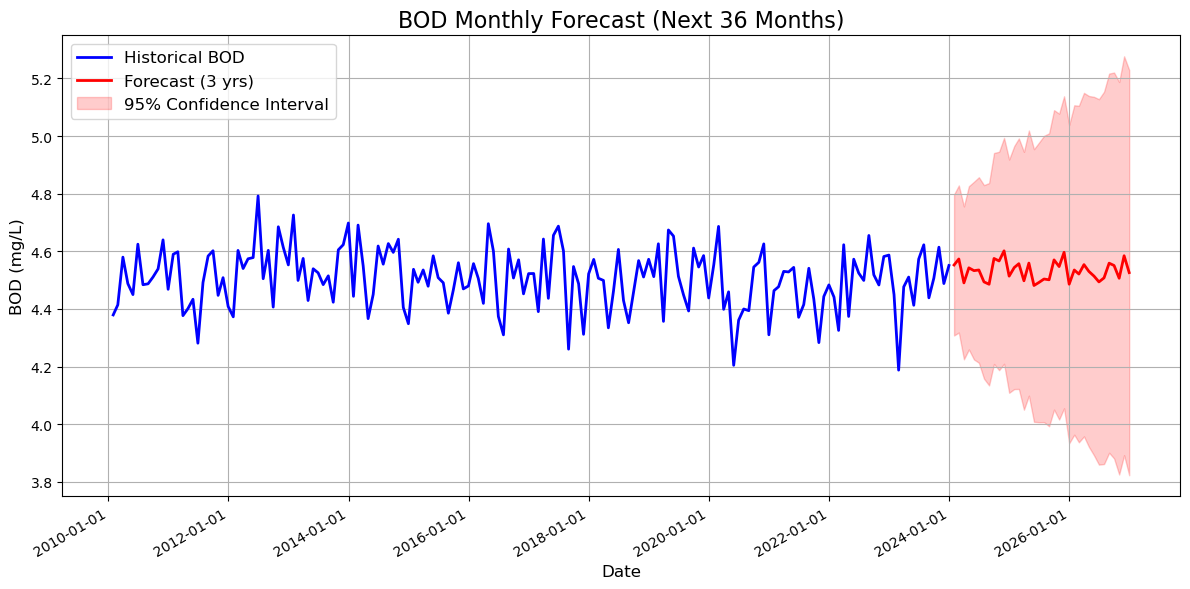


Forecast Summary:
            Forecast  Lower CI  Upper CI
2024-01-31  4.552347  4.307679  4.797014
2024-02-29  4.573261  4.318001  4.828522
2024-03-31  4.490303  4.224922  4.755683
2024-04-30  4.542492  4.259250  4.825734
2024-05-31  4.532796  4.224485  4.841106
2024-06-30  4.535033  4.213071  4.856994
2024-07-31  4.493744  4.157904  4.829584
2024-08-31  4.485549  4.134425  4.836672
2024-09-30  4.575021  4.209049  4.940993
2024-10-31  4.566339  4.187319  4.945358
2024-11-30  4.601450  4.209511  4.993389
2024-12-31  4.513651  4.108894  4.918407
2025-01-31  4.543504  4.121729  4.965278
2025-02-28  4.556907  4.122172  4.991643
2025-03-31  4.497568  4.050170  4.944966
2025-04-30  4.558969  4.098769  5.019169
2025-05-31  4.481218  4.008210  4.954227
2025-06-30  4.491722  4.006733  4.976710
2025-07-31  4.503733  4.006992  5.000473
2025-08-31  4.501026  3.992695  5.009357
2025-09-30  4.570102  4.050435  5.089770
2025-10-31  4.546903  4.016209  5.077596
2025-11-30  4.596429  4.054914  5.1379

/var/folders/6f/hrr6km6x5l39n_12_r7994t00000gn/T/ipykernel_37818/950111308.py:140: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  }, index=pd.date_range(start=forecast_start, periods=36, freq='M'))


In [12]:
def plot_seasonal_decompose(series):
    
    result = seasonal_decompose(series, model='additive')
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    
    axes[0].plot(result.observed, color='steelblue', linewidth=2)
    axes[0].set_title('Observed', fontsize=14)
    axes[0].grid(True)
    
    axes[1].plot(result.trend, color='steelblue', linewidth=2)
    axes[1].set_title('Trend', fontsize=14)
    axes[1].grid(True)
    
    axes[2].plot(result.seasonal, color='steelblue', linewidth=2)
    axes[2].set_title('Seasonal', fontsize=14)
    axes[2].grid(True)
    
    axes[3].plot(result.resid, color='steelblue', linewidth=2)
    axes[3].set_title('Residual', fontsize=14)
    axes[3].grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_diagnostics(results):
   
    fig = results.plot_diagnostics(figsize=(16, 8))
    plt.tight_layout()
    plt.show()

def forecast_bod_3yr(df, date_col="sample_date_time", param_col="BOD"):
    
    df = df.dropna(subset=[param_col]).copy()
    
    df["zscore"] = zscore(df[param_col])
    df = df[df["zscore"].abs() < 3].copy()
    
    df = df[(df[param_col] >= 3) & (df[param_col] <= 6)].copy()
    
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df.sort_values(by=date_col, inplace=True)
    df.set_index(date_col, inplace=True)
    
    # resample data to monthly means
    df_monthly = df[param_col].resample("M").mean().dropna()
    
    if len(df_monthly) < 12:
        raise ValueError("Not enough data after filtering and resampling.")
    
    # plot seasonal decomposition
    plot_seasonal_decompose(df_monthly)
    
    try:
        # fit auto ARIMA model
        auto_model = auto_arima(df_monthly, seasonal=True, m=12,
                                start_p=0, start_q=0, max_p=5, max_q=5,
                                start_P=0, start_Q=0, max_P=5, max_Q=5,
                                d=1, D=1, trace=True, error_action='ignore',
                                suppress_warnings=True, stepwise=True)
        
        results = auto_model.fit(df_monthly)
        print(results.summary())
        
        # plot model diagnostics
        plot_diagnostics(results)
        
    except Exception as e:
        print(f"Error fitting the auto ARIMA model: {e}")
        return None, None
    
    # forecast for 3 years (36 months)
    forecast_steps = 36
    forecast_vals, conf_int = results.predict(n_periods=forecast_steps, return_conf_int=True)
    
    # create future index for plotting
    future_index = pd.date_range(start=df_monthly.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='M')
    
    # plot historical data and forecast with confidence intervals
    plt.figure(figsize=(12, 6))
    
    plt.plot(df_monthly.index, df_monthly, label="Historical BOD", color="blue", linewidth=2)
    plt.plot(future_index, forecast_vals, label="Forecast (3 yrs)", color="red", linewidth=2)
    plt.fill_between(
        future_index,
        conf_int[:, 0],
        conf_int[:, 1],
        color="red",
        alpha=0.2,
        label="95% Confidence Interval"
    )
    
    plt.title(f"{param_col} Monthly Forecast (Next 36 Months)", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel(f"{param_col} (mg/L)", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

    return forecast_vals, conf_int

if __name__ == "__main__":
    date_rng = pd.date_range("2010-01-01", "2023-12-01", freq="D")
    np.random.seed(42)
    synthetic_bod = 4.5 + np.random.normal(loc=0, scale=0.6, size=len(date_rng))
    
    df_demo = pd.DataFrame({
        "sample_date_time": date_rng,
        "BOD": synthetic_bod
    })
    
    forecast_vals, conf_int = forecast_bod_3yr(df_demo, date_col="sample_date_time", param_col="BOD")
    
    
    if forecast_vals is not None:
        print("\nForecast Summary:")
        last_date = df_demo['sample_date_time'].max()
        forecast_start = last_date + pd.offsets.MonthBegin(1)
        summary_df = pd.DataFrame({
            'Forecast': forecast_vals,
            'Lower CI': conf_int[:, 0],
            'Upper CI': conf_int[:, 1]
        }, index=pd.date_range(start=forecast_start, periods=36, freq='M'))
        print(summary_df)

